# Facial Detection Using Machine Learning Techniques - Intro

## Project Overview

This Jupyter Notebook presents an implementation of a face detection system using traditional Machine Learning techniques. Although deep learning-based approaches have become more prominent in recent years, the earlier methods retain their relevance due to their computational efficiency and robustness. A prime example of such an approach is the Viola-Jones face detector.

The purpose of this project is to build face detectors from classifiers. Instead of directly working with pixels, we'll use features extracted from the images. Our main goal is to develop computationally light classifiers capable of determining whether a given image is a face.

The project follows the following steps:

1. **Preprocessing**: Define the initial treatment of images, such as normalization, scaling, and application of general transformations.
2. **Features**: Define the process of extracting Haar features and building the feature matrix.
3. **Classifiers**: Implement classification algorithms seen in the course, including ensemble techniques.
4. **Model Evaluation**: Evaluate different classifiers using validation and evaluation techniques seen in the course.
5. **Attentional Cascade**: Implement the cascading classification mechanism.

## Dataset

The dataset consists of grayscale images, with pixel values ranging from 0 (black) to 255 (white). Of the `N` images, `p` are faces (positive examples) and $n$ are backgrounds (negative examples).


# Setting Up the Environment using Conda

## Pre-requisites

1. **Python:** This project is written in Python, an interpreted high-level general-purpose programming language. Python must be installed on your machine. You can verify if Python is installed by typing $python --version` into your terminal. If Python is installed, this command should return a version number.

2. **Conda:** Conda is an open-source package management system and environment management system. You should have Conda installed on your machine. To confirm, type `conda --version` in your terminal. If Conda is installed, this command will return a version number.

If Python or Conda are not installed on your machine, you can download them from the [official Python website](https://www.python.org/) and [official Anaconda website](https://www.anaconda.com/products/distribution) respectively.

## Conda Environment

After ensuring that Python and Conda are installed, create a virtual environment for the project.

1. **Create the environment**: We have provided an `environment.yml` file which contains a list of all the Python packages needed for the project. To create a new environment using this file, use the following command:

```bash
conda env create -f environment.yml
```

2. **Activate the environment**: After the new environment has been created, activate it with:

```bash
conda activate face_detection
```



In [1]:
from time import time
from tqdm import tqdm
import os

import pickle

import random

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from xgboost import XGBClassifier


from collections import Counter

import warnings
from sklearn.exceptions import ConvergenceWarning

from skimage.exposure import equalize_hist
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from sklearn.feature_selection import SelectPercentile, f_classif

In [2]:
# setting seed for reproducibility
SEED = 34
random.seed(SEED)
np.random.seed(SEED)

# Introduction
In this Jupyter notebook, we will embark on the first step of our Face Detection project: loading and exploring the dataset. This initial phase is crucial as it helps us to understand the data we're working with and to inform the subsequent steps in our machine learning workflow.

The dataset consists of grayscale images, representing both faces (positive examples) and non-faces (negative examples). The positive examples are images of faces, while the negative examples are images taken from scenes that contain everything but faces. The images are all of the same size, and the faces in the positive examples are aligned and scaled to fit the images.

# Loading the Dataset
We will start by loading the dataset. The images are stored in a [pgm format](https://netpbm.sourceforge.net/doc/pgm.html), which is a simple format for grayscale images.

In [3]:
TRAIN_FACES_DIR = "data/train/face/"
TRAIN_BACKGROUND_DIR = "data/train/non-face/"
TEST_FACES_DIR = "data/test/face/"
TEST_BACKGROUND_DIR = "data/test/non-face/"


def load_name_images(directory):
    return [f for f in os.listdir(directory) if f.endswith(".pgm")]


# Load the dataset
train_faces = load_name_images(TRAIN_FACES_DIR)
train_background = load_name_images(TRAIN_BACKGROUND_DIR)
test_faces = load_name_images(TEST_FACES_DIR)
test_background = load_name_images(TEST_BACKGROUND_DIR)

# Exploratory Data Analysis
After loading the data, we will perform an exploratory data analysis (EDA). This is where we examine the data, look for anomalies, study its structure, and visualize it through various kinds of plots. The goal of this stage is to find patterns, spot anomalies, or check assumptions with the help of summary statistics and graphical representations.

The following tasks will be performed during the EDA:

1. **Viewing the images**: We will view some of the face and non-face images to get an idea of what our data looks like.

2. **Checking the balance of the dataset**: It is crucial to know if the data is balanced or imbalanced. If the data is imbalanced, it might impact the performance of our machine learning model, and we'll need to address this.

3. **Basic Statistics**: We'll calculate some basic statistics to get a better sense of our data.

This initial exploration will help us get familiar with the dataset and gain valuable insights that will guide us in the rest of the project.

## Viewing the Images
Let's start by viewing some of the images in our dataset. We'll use the `imshow()` and `imread()` functions from the `matplotlib` library to load and display the images.

In [4]:
def load_images(directory, names):
    return [
        plt.imread(directory + name)
        for name in tqdm(names, desc="Loading images from " + directory)
    ]


# Load the trining images
train_faces_images = load_images(TRAIN_FACES_DIR, train_faces)
train_background_images = load_images(TRAIN_BACKGROUND_DIR, train_background)

# Create the training set
X_train = np.array(train_faces_images + train_background_images)
# Create the labels (1 for faces, 0 for non-faces)
y_train = np.array([1] * len(train_faces_images) + [0] * len(train_background_images))

# Load the test images
test_faces_images = load_images(TEST_FACES_DIR, test_faces)
test_background_images = load_images(TEST_BACKGROUND_DIR, test_background)

# Create the test set
X_test = np.array(test_faces_images + test_background_images)
# Create the labels (1 for faces, 0 for non-faces)
y_test = np.array([1] * len(test_faces_images) + [0] * len(test_background_images))


# Drop a percentage of the set to speed up the training and testing
def drop_data(X, y, percentage=0.5):
    index = np.random.choice(len(X), int(len(X) * percentage), replace=False)
    return X[index], y[index]

Loading images from data/test/non-face/: 100%|██████████| 23573/23573 [00:01<00:00, 22303.80it/s]


In [5]:
# print shapes
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (6977, 19, 19)
y_train shape: (6977,)
X_test shape: (24045, 19, 19)
y_test shape: (24045,)


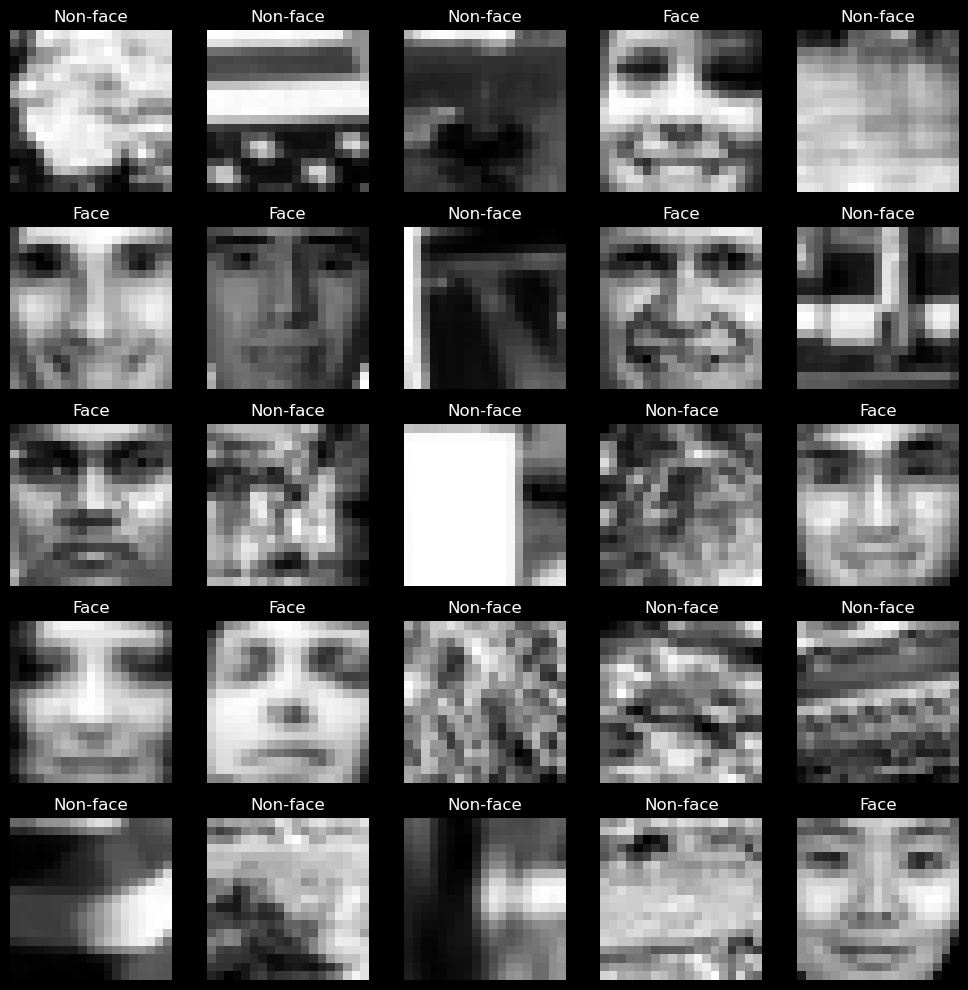

In [6]:
def plot_image(images, labels):
    # select 25 random images
    random_indices = np.random.choice(images.shape[0], size=25, replace=False)
    random_images = images[random_indices]
    random_labels = labels[random_indices]

    # plot the 25 random images, with their labels
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        ax.imshow(random_images[i], cmap="gray")

        ax.set_title("Face" if random_labels[i] else "Non-face")

        ax.axis("off")

    plt.tight_layout()

    plt.show()

# Plot the training set
plot_image(X_train, y_train)

## Checking the Balance of the Dataset

Before proceeding with modeling, it's crucial to examine the balance of our dataset. A balanced dataset refers to one where the number of samples in each class are approximately equal. If our dataset is severely imbalanced, it might negatively impact the performance of our model, leading it to be biased towards the majority class.

In the context of our face detection task, we need to ensure that we have an approximately equal number of face and non-face images. This step will ensure that our model gets enough exposure to both classes during training, leading to a more robust and generalizable model.

Let's perform a check on our dataset to see how well balanced it is.


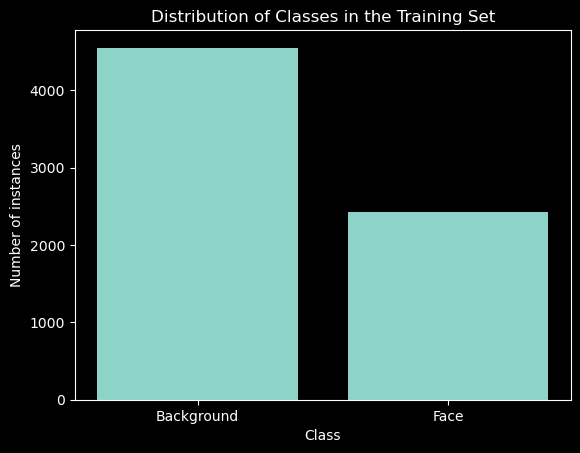

In [7]:
# Count the number of each class
counter = Counter(y_train)

# Create a bar chart
plt.bar(counter.keys(), counter.values())
plt.title("Distribution of Classes in the Training Set")
plt.xlabel("Class")
plt.ylabel("Number of instances")
plt.xticks(list(counter.keys()), ["Face", "Background"])
plt.show()

In [8]:
face_percentage = (len(train_faces_images) / len(X_train)) * 100

print(f"Percentage of faces in the training set: {face_percentage:.2f}%")

Percentage of faces in the training set: 34.81%


Our dataset presents a mild imbalance, with 34.81% of the images being faces. This is not a severe imbalance, and we can proceed with the statisctics step. Also, in next steps, we will use techniques to address this imbalance like use evaluation metrics that are robust to imbalanced datasets.

## Basic Statistics

In the context of our face detection task, understanding the distribution of pixel values across our images can provide valuable insights for preprocessing steps and overall algorithm improvement. 

In grayscale images, pixel values range from 0 (black) to 255 (white). By analyzing these values, we can obtain information about aspects such as image brightness and contrast which are crucial for effective feature extraction and object detection.

We can calculate a histogram to visualize the frequency distribution of pixel values. This, along with descriptive statistics such as mean, median, and standard deviation, can guide us towards appropriate preprocessing methods, for instance, brightness and contrast adjustments.

Let's now proceed to analyze the distribution of pixel values in our dataset.



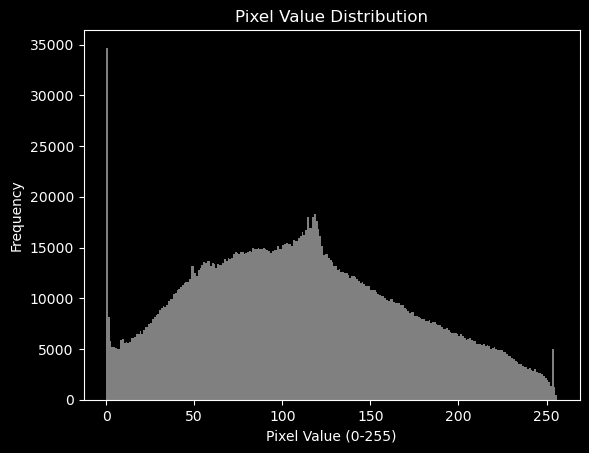

Mean pixel value: 110.51405587889293
Median pixel value: 107.0
Standard Deviation of pixel values: 60.30700268765547


In [9]:
def basic_stats(images, range=(0, 256)):
    # Flatten the array to 1D for histogram and statistics
    pixels = images.flatten()

    # Generate histogram
    plt.hist(pixels, bins=256, range=range, color="gray")
    plt.title("Pixel Value Distribution")
    plt.xlabel("Pixel Value (0-255)")
    plt.ylabel("Frequency")
    plt.show()

    # Calculate and print basic statistics
    mean_value = np.mean(pixels)
    median_value = np.median(pixels)
    std_dev = np.std(pixels)

    print(f"Mean pixel value: {mean_value}")
    print(f"Median pixel value: {median_value}")
    print(f"Standard Deviation of pixel values: {std_dev}")


basic_stats(X_train)

In reviewing the statistics and visualizations of our dataset, there are several key conclusions we can draw:

- **Histogram**: The distribution of pixel values across the entire range, with a clear concentration in the middle, suggests that our images generally have good contrast and range of pixel intensities. However, the majority of pixels fall within medium-intensity levels, suggesting that our images are generally neither too dark nor too light. Additionally, there is a significant spike at the value of 0, corresponding to white pixels. This is likely due to color truncation by the camera sensors, which often struggle to capture detail in extremely bright areas, leading to these areas being recorded as pure white.

- **Mean and Median**: The close proximity of the mean and median indicates that the pixel intensity distribution is fairly symmetrical without significant outliers skewing the mean. This is a positive sign, suggesting that outlier values within our data may not be a significant concern.

- **Standard Deviation**: A standard deviation of approximately 60 is relatively high, indicating a substantial amount of variation in the pixel values across our images. This means that our images span a wide range of pixel intensities, from dark to light. This could potentially benefit our facial recognition classifier, as it implies that our model will have the opportunity to learn to recognize faces across various lighting conditions.

Even with these insights, we are planning to perform equalization as a part of preprocessing, which would help to distribute pixel intensities across the full range more evenly, potentially enhancing the contrast and details within the images. 

After applying the equalization, we will reassess these statistics to ensure that our preprocessing has had the desired effect and that our data is in a suitable state for model training. 



# Image Preprocessing

Image preprocessing is a critical step in computer vision tasks. Proper preprocessing can significantly improve the performance of your models by making the raw input data more suitable for analysis.

The primary aim of preprocessing in our project is to standardize the images, enhancing the contrast and bringing out the relevant features more prominently. This step becomes especially important when working with grayscale images as in our case, where contrast plays a crucial role in feature detection.


## Histogram Equalization

One of the preprocessing techniques we will be using is [Histogram Equalization](https://en.wikipedia.org/wiki/Histogram_equalization). Histogram Equalization is a method that improves the contrast in an image, in order to stretch out the intensity range. It does so by effectively spreading out the most frequent intensity values, i.e., enhancing the contrast where there are a lot of close intensity values. This method is useful when an image contains foregrounds and backgrounds that both are bright or both are dark.

The function `equalize_hist` from `skimage.exposure` module will be used for this purpose. This function equalizes the image histogram, which flattens the grayscale histogram of the image, enhancing the contrast.

Let's proceed with the preprocessing.

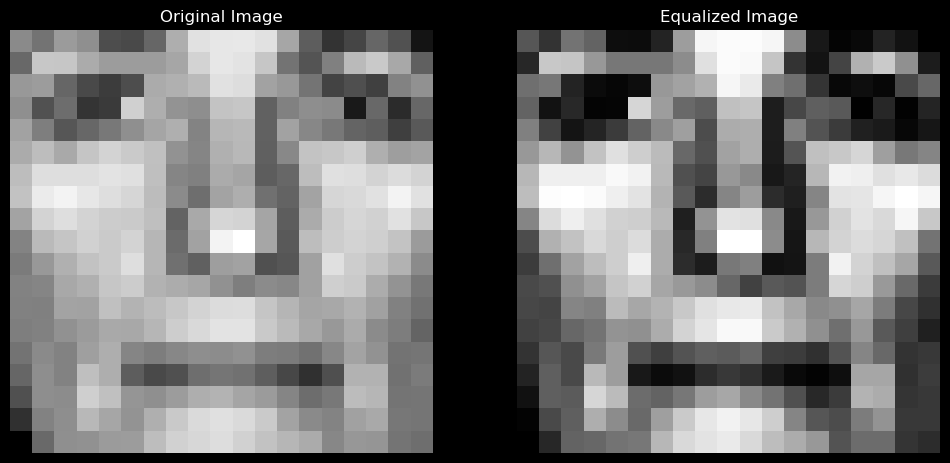

In [10]:
# Choose an image to transform
test_image_index = min(1269, len(X_train) - 1)

# Equalize histogram
original_image = X_train[test_image_index]
image_equalized = equalize_hist(original_image)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display original image
ax[0].imshow(original_image, cmap="gray")
ax[0].set_title("Original Image")
ax[0].axis("off")

# Display image after histogram equalization
ax[1].imshow(image_equalized, cmap="gray")
ax[1].set_title("Equalized Image")
ax[1].axis("off")

plt.show()

In [11]:
# Equalize the training and test sets
X_train_norm = np.array([equalize_hist(image) for image in X_train])
X_test_norm = np.array([equalize_hist(image) for image in X_test])

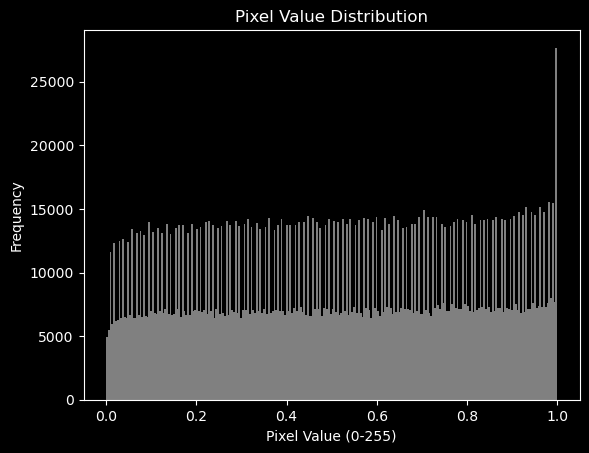

Mean pixel value: 0.513432912449607
Median pixel value: 0.5152354570637119
Standard Deviation of pixel values: 0.2892390351970039


In [12]:
basic_stats(X_train_norm, range=(0, 1))

Upon applying the histogram equalization to our images, we can observe a noticeable shift in the image's histogram. The pixel intensity distribution is now spread out evenly across the entire range (from 0 to 256). This indicates that the contrast of the image has been enhanced and that the details within different intensity regions are now more discernible. This procedure will be beneficial to our model training as it can help our model better recognize features in different intensity regions. We will apply this equalization process to all the images in our dataset during the preprocessing phase.


## Resizing

Images in a dataset can come in different sizes and resolutions. However, machine learning models often require a fixed input size, which means we usually need to resize our images to have the same width and height before feeding them into the model. 

To approach this, the first step will be to verify the sizes of our images in the current dataset to understand better what we're dealing with. It's crucial to check whether all our images have the same dimensions. If that's the case, we might not need to do any resizing. 

Let's go ahead and check the sizes of our images.


In [13]:
image_sizes = [img.shape for img in X_train_norm]

# Check if all images have the same size
if len(set(image_sizes)) == 1:
    print(f"All images have the same size: {image_sizes[0]}")
else:
    print(f"Images have varying sizes. Here are some examples: {image_sizes[:5]}")

All images have the same size: (19, 19)


We have verified that all images in our dataset have a consistent size of 19x19 pixels. This uniformity is advantageous, as it eliminates the need for potentially distorting resize operations.

Given that all our images are already of the same dimensions, and the dimension size is relatively small, we have decided not to perform any resizing on our images during the training process. The reasoning behind this decision is to retain as much of the original image information as possible and prevent potential distortions or loss of details that could arise from resizing.


## Haar Features

In the context of our image classification task, our main objective is to create lightweight classifiers that can efficiently determine whether an image is a face or not. To achieve this, we will work with features extracted from the images, rather than the raw pixel data itself.

We construct a feature matrix $X$, where each row represents an image and each column a feature. We choose $M$ features $f_j$ for $j = 1,...,M$, such that the entry $i, j$ of the matrix $X$ is $f_j(x_i)$. The pair $(X, y)$, where $y$ is the label vector, will serve as input to the classifiers.

To extract these features, we use a set of standard features known as **Haar features**. The advantage of Haar features lies in their computational speed. Instead of using computationally expensive multiplications, they simply sum and subtract pixel values in the image.

A Haar feature is defined as:

$$
f(x) = \sum_{i=0}^{H-1}\sum_{j=0}^{W-1} pb(i, j) - pn(i, j)
$$

Where $pb(i, j)$ is 1 if the pixel $(i, j)$ is white and 0 if not, and similarly for $pn(i, j)$. 

These features can be interpreted intuitively. For instance, one Haar feature measures the intensity difference between the eye region and the upper cheek region. It is based on the fact that the eye region is generally darker than the cheeks. Another feature compares intensities in the eye regions with the intensity in the nose.

To calculate these features efficiently, we use an intermediate image representation called **integral image**. The integral image $I(x)$ at position $(i, j)$ is equal to the sum of pixels above and to the left of $(i, j)$, inclusive:

$$
I(x)_{ij} = \sum_{i'\leq i, j'\leq j} x_{i'j'}
$$

The integral image can be quickly calculated in one pass over the image.


### Integral Image

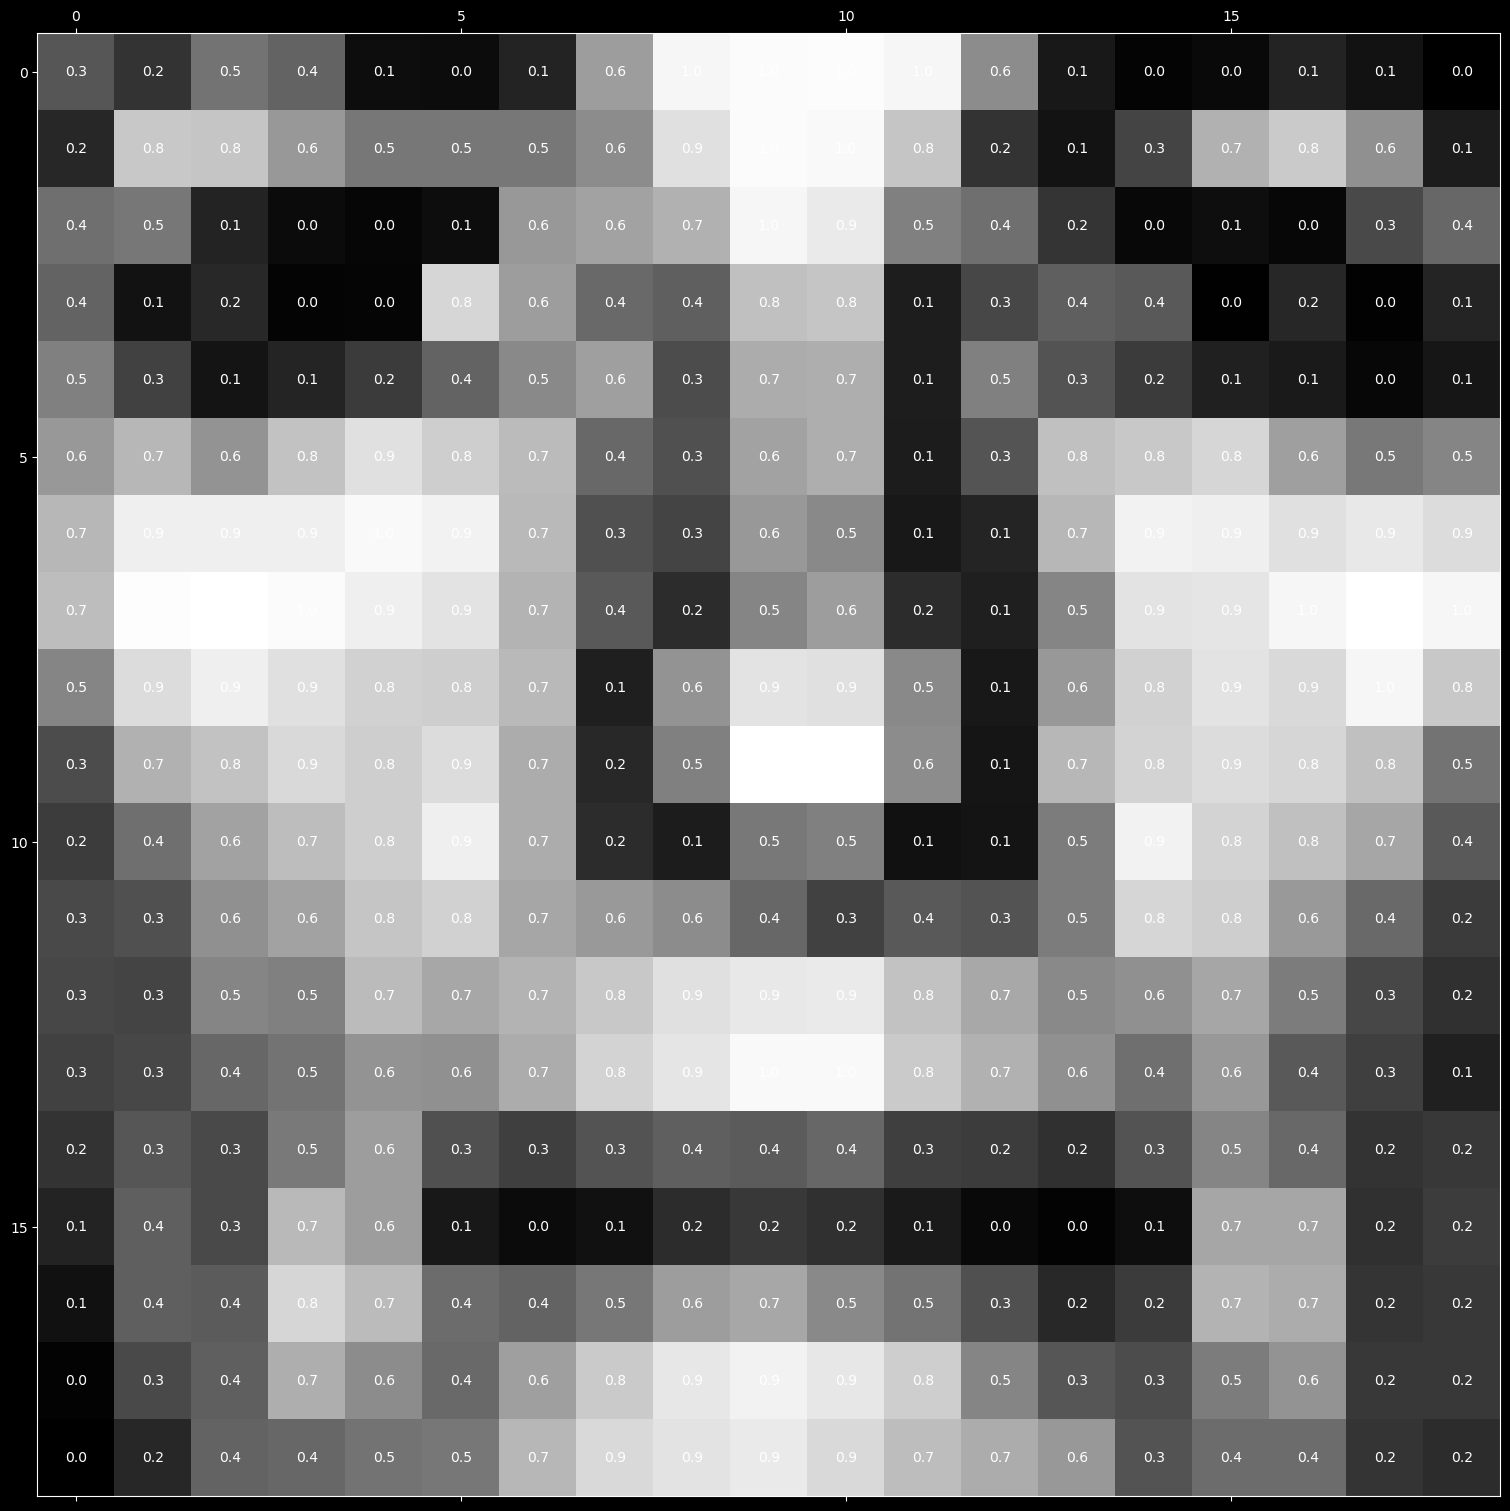

In [14]:
image = X_train_norm[test_image_index]

fig, ax = plt.subplots(figsize=(image.shape[0], image.shape[1]))

min_val, max_val = image.min(), image.max()

ax.matshow(image, cmap="gray")

for i in range(image.shape[1]):
    for j in range(image.shape[0]):
        c = np.round(image[j, i], 1)
        ax.text(i, j, str(c), va="center", ha="center")

plt.show()

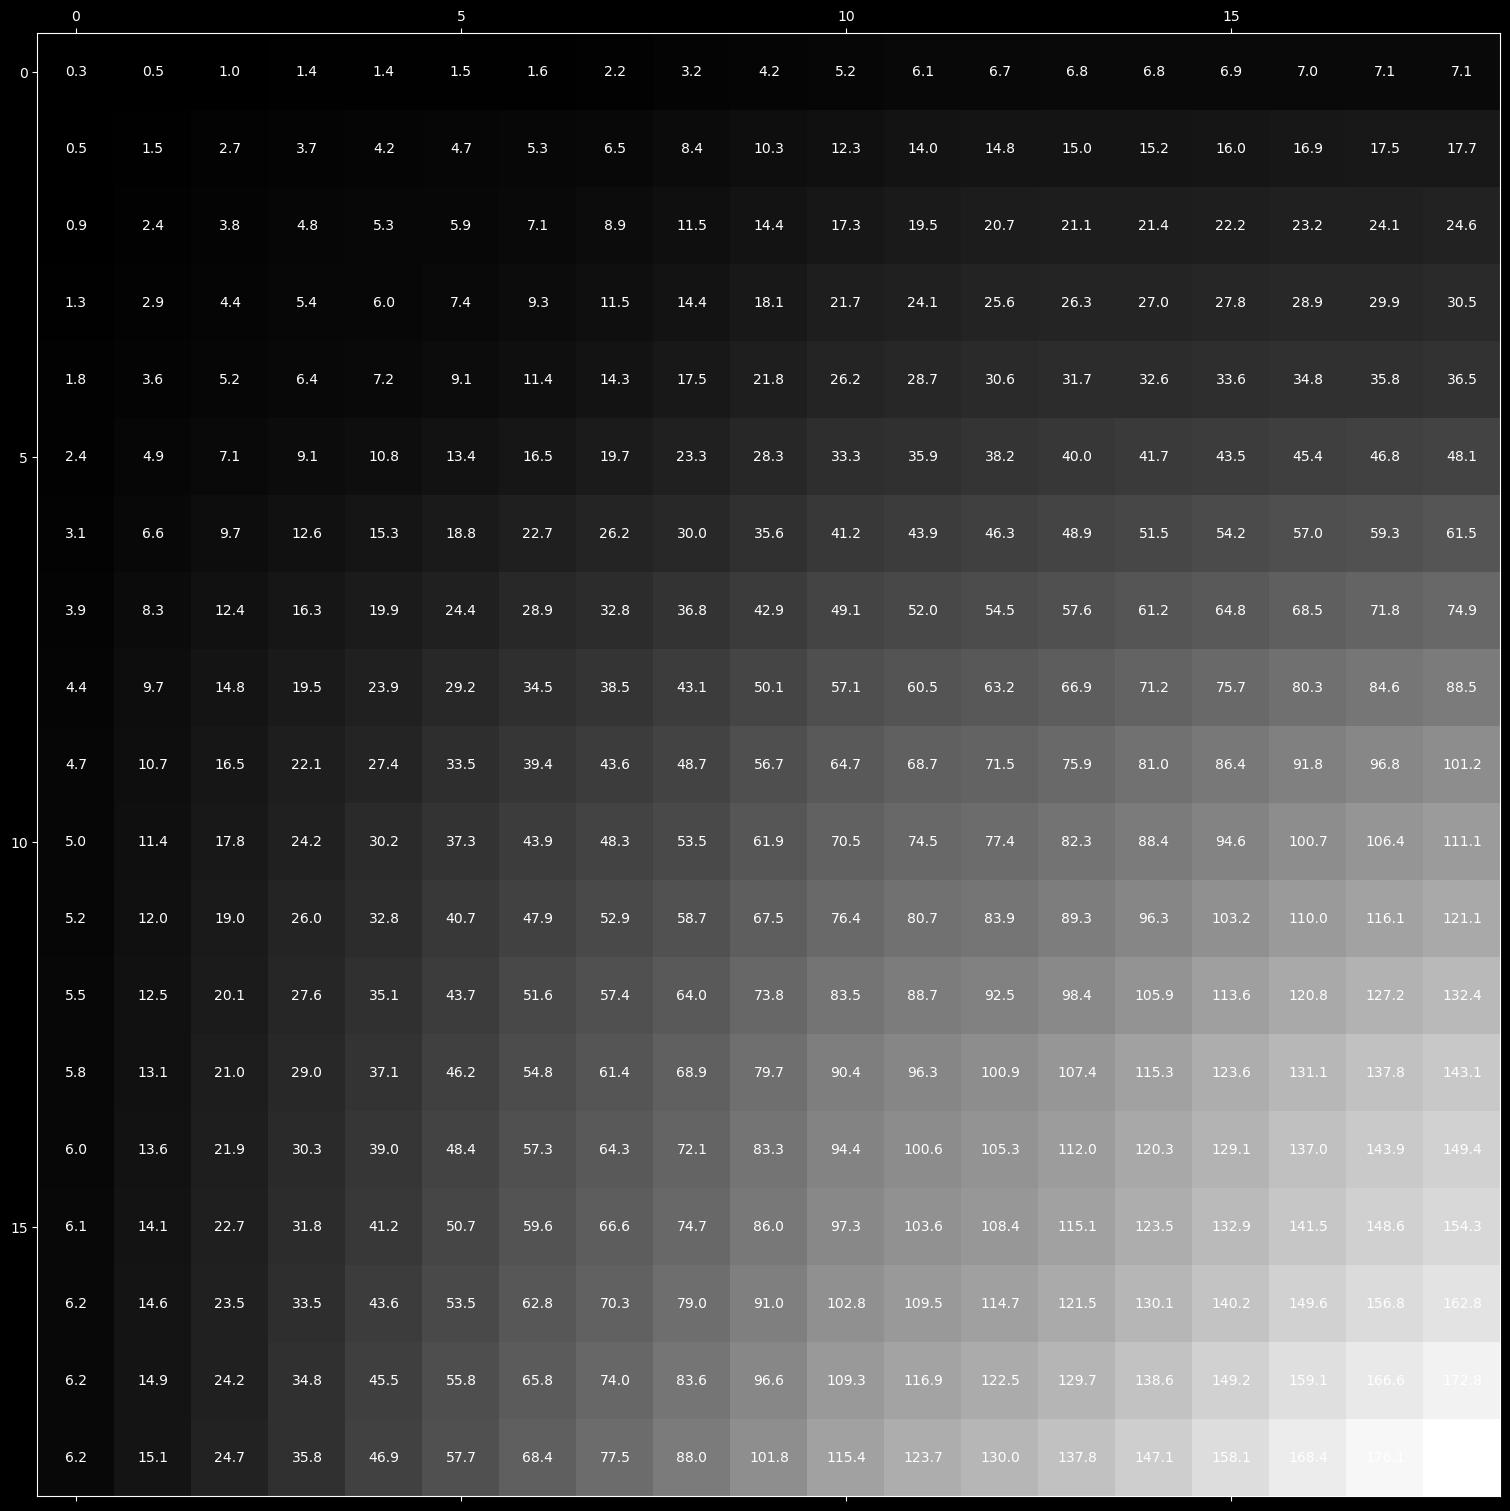

In [15]:
ii = integral_image(image)

fig, ax = plt.subplots(figsize=(image.shape[0], image.shape[1]))

min_val, max_val = ii.min(), ii.max()

ax.matshow(ii, cmap="gray")

for i in range(image.shape[1]):
    for j in range(image.shape[0]):
        c = np.round(ii[j, i], 1)
        ax.text(i, j, str(c), va="center", ha="center", c="white")

plt.show()

## Haar-like Features

The next step in the process involves the calculation of the Haar-like features. Haar-like features are visual features used in image processing. They're called "Haar-like" because they resemble the Haar wavelets. These features are essentially simple rectangular features that can be rapidly calculated from an image.

There are three types of Haar-like features:

Edge features: These features are useful to capture the change in intensity from one region of an image to another.

Line features: These features help in capturing the variations in intensity along a line in a particular direction.

Four-rectangle features: They can be used to identify more complex patterns in an image.

In the context of our problem, these Haar-like features will allow us to capture important information from the images, such as the presence of specific shapes or structures, and encode this information in a manner that can be readily used by our classifiers.

It's important to remember that Haar-like features do not give us any information about the color of the image, they're solely based on the intensity values of the pixels. In our case, since we're working with grayscale images, these features are very suitable.

In the next step, we'll calculate the Haar-like features for our images and use them to populate the feature matrix, $X$. After this, $X$ will serve as an input for our classifiers.

In [16]:
# Define Haar-like features
# type-2-x: 2 rectangles, horizontally aligned, top-left and top-right
# type-2-y: 2 rectangles, vertically aligned, top-left and bottom-left
# type-3-x: 3 rectangles, horizontally aligned, top-left, top-right and bottom-right
# type-3-y: 3 rectangles, vertically aligned, top-left, bottom-left and bottom-right
# type-4: 4 rectangles, 2-by-2 grid, top-left, top-right, bottom-left and bottom-right
feature_types = ["type-2-x", "type-2-y", "type-3-x", "type-3-y", "type-4"]

# Compute the Haar-like features
haar_features = haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1], feature_types)

In [17]:
haar_features.shape

(63960,)

In [18]:
haar_features[0]

-0.13850415512465375

In [19]:
feature_coord, feature_type = haar_like_feature_coord(
    width=image.shape[1], height=image.shape[0], feature_type=feature_types
)

In [20]:
feature_coord[0]

[[(0, 0), (0, 0)], [(0, 1), (0, 1)]]

In [21]:
feature_type[0]

'type-2-x'

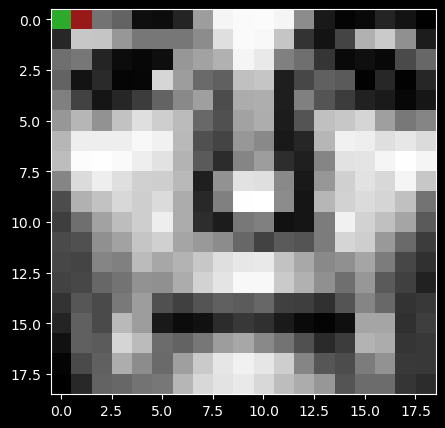

In [22]:
plt.figure(figsize=(5, 5))

feature_image = draw_haar_like_feature(
    image, 0, 0, image.shape[1], image.shape[0], [feature_coord[0]]
)

plt.imshow(feature_image, cmap="gray")
plt.show()

## Feature Matrix

The feature matrix $X$ is a matrix of size $N \times M$, where $N$ is the number of images in the dataset and $M$ is the number of features. Each row of the matrix represents an image, and each column represents a feature. The entry $i, j$ of the matrix $X$ is $f_j(x_i)$, where $f_j$ is the $j$-th feature and $x_i$ is the $i$-th image.

In [23]:
def extract_feature_image(img, feature_type=None, feature_coord=None):
    ii = integral_image(img)
    return haar_like_feature(
        ii,
        0,
        0,
        ii.shape[0],
        ii.shape[1],
        feature_type=feature_type,
        feature_coord=feature_coord,
    )

In [24]:
index_backup_path = "f_index.pkl"
index_backup_exists = os.path.exists(index_backup_path)

if index_backup_exists:
    with open(index_backup_path, "rb") as f:
        f_indices = pickle.load(f)

In [25]:
train_feature_types = feature_types
train_feature_coord = None
if index_backup_exists:
    train_feature_types = feature_type[f_indices]
    train_feature_coord = feature_coord[f_indices]

F_train = [
    extract_feature_image(
        img, feature_type=train_feature_types, feature_coord=train_feature_coord
    )
    for img in tqdm(X_train_norm)
]
F_train = np.array(F_train)

100%|██████████| 6977/6977 [00:09<00:00, 752.35it/s]


In [26]:
# save the most important features if they don't exist, or load them if they do
if not index_backup_exists:
    f_indices = (
        SelectPercentile(f_classif, percentile=10)
        .fit(F_train, y_train)
        .get_support(indices=True)
    )
    with open(index_backup_path, "wb") as f:
        pickle.dump(f_indices, f)
    TopF_train = F_train[:, f_indices]
else:
    TopF_train = F_train

In [27]:
# Calculate those features for the test set
TopF_test = [
    extract_feature_image(
        img,
        feature_type=feature_type[f_indices],
        feature_coord=feature_coord[f_indices],
    )
    for img in tqdm(X_test_norm)
]
TopF_test = np.array(TopF_test)

100%|██████████| 24045/24045 [00:34<00:00, 701.64it/s]


# Classification Algorithms and Ensemble Techniques

Classification in machine learning refers to the task of predicting the discrete class labels of instances based on their features. With our feature matrix $X$, which we derived using Haar-like features, and our target vector $y$, which provides the true labels for each instance, we are prepared to train classification models. The aim is to predict whether a given image represents a face.

Numerous classification algorithms exist, each with its strengths and weaknesses. We will explore several of them in this context:

1. **Logistic Regression**: Logistic Regression is a statistical model primarily used in binary classification problems. It models the probability of the default class, or in our case whether an image is a face or not.

2. **Decision Tree**: Decision Tree classifiers predict the value of the target variable based on decision rules inferred from the data features. They provide interpretable models and handle both numerical and categorical data.

3. **Bagging**: Bagging (or Bootstrap Aggregating) is an ensemble learning technique that constructs multiple base models independently and then combines their outputs (via voting or averaging) to make a final prediction.

4. **Random Forest**: Random Forest is an extension of bagging, but it introduces more randomness when constructing each individual model, resulting in diverse trees. These diverse models collectively yield a more robust and accurate prediction.

5. **AdaBoost**: AdaBoost is a boosting type of ensemble learning model that works by focusing on instances that previous models misclassified and trying to correct them. The final prediction is a weighted sum of the predictions made by previous models.

6. **Gradient Boosting**: Gradient Boosting also belongs to the boosting category of ensemble learning models. It differs from AdaBoost by using gradient descent to minimize the loss when adding new models.

7. **XGBoost**: XGBoost stands for Extreme Gradient Boosting. It is a more efficient version of the gradient boosting algorithm, designed to increase computational speed and efficiency.

In the sections that follow, we will implement and evaluate these classifiers on our dataset. In addition, we will discuss how to evaluate the performance of our classifiers and select the model that performs best.


In [28]:
def evaluate(model, X_train, X_test, y_train, y_test, threshold=0.5):
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_pred_proba > threshold).astype(int)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_train_pred = (y_train_pred_proba > threshold).astype(int)

    print("TRAINIG RESULTS:")
    clf_report = pd.DataFrame(
        classification_report(y_train, y_train_pred, output_dict=True)
    )
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    confusion_matrix(y_train, y_train_pred)
    print(f"ACCURACY SCORE:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print("AUC: %.3f" % roc_auc_score(y_train, y_train_pred_proba))

    print("=============================== \nTESTING RESULTS:")
    clf_report = pd.DataFrame(
        classification_report(y_test, y_test_pred, output_dict=True)
    )
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print("AUC: %.3f" % roc_auc_score(y_test, y_test_pred_proba))

## Hyperparameter Tuning with Cross Validation

So far, we have applied various classification models to our face detection problem. However, each model comes with a set of hyperparameters that can significantly impact its performance. A hyperparameter is a parameter that is not learned directly within the estimators. In scikit-learn, these are passed as arguments to the constructor of the estimator classes. 

One of the strategies to perform hyperparameter optimization is grid search. Grid search is an approach to hyperparameter tuning that methodically builds and evaluates a model for each combination of algorithm parameters specified in a grid. 

The GridSearchCV function in Scikit-learn library helps to loop through predefined hyperparameters and fit your estimator (model) on your training set. So, in the end, you can select the best parameters from the listed hyperparameters.

However, just performing a Grid Search might lead to overfitting, as we are selecting the hyperparameters that perform the best on the training data. To avoid this, we use Cross Validation.

Cross-validation is a powerful preventative measure against overfitting. The idea is clever: Use your initial training data to generate multiple mini train-test splits. Use these splits to tune your model.

In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:
- A model is trained using `k-1` of the folds as training data;
- The resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as it is the case when fixing an arbitrary validation set), which is a major advantage in problems such as ours where the number of samples is very small.

In the next steps, we will use GridSearchCV with different classifiers, optimizing a set of hyperparameters and using cross validation to select the best model in terms of validation performance.

Importantly, we will be using the Area Under the Curve (AUC) of the Receiver Operating Characteristic (ROC) as our scoring metric during hyperparameter tuning. AUC-ROC is a performance measurement for the classification problems at various thresholds settings. ROC is a probability curve and AUC represents the degree or measure of separability - how much the model is capable of distinguishing between classes. The higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. Therefore, by optimizing the AUC during GridSearchCV, we aim to create a model with the best possible classification performance.


In [29]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}

logreg = LogisticRegression(max_iter=1000)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    grid_search = GridSearchCV(
        logreg, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1
    )
    grid_search.fit(TopF_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

logreg = grid_search.best_estimator_
evaluate(logreg, TopF_train, TopF_test, y_train, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/k/miniconda3/envs/face_detection/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/k/miniconda3/envs/face_detection/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Best parameters: {'C': 0.01}
Best score: 0.9977138146770802
TRAINIG RESULTS:
CONFUSION MATRIX:
[[4514   34]
 [  43 2386]]
ACCURACY SCORE:
0.9890
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.990564     0.985950  0.988964     0.988257      0.988958
recall        0.992524     0.982297  0.988964     0.987411      0.988964
f1-score      0.991543     0.984120  0.988964     0.987832      0.988959
support    4548.000000  2429.000000  0.988964  6977.000000   6977.000000
AUC: 0.999
TESTING RESULTS:
CONFUSION MATRIX:
[[23249   324]
 [  399    73]]
ACCURACY SCORE:
0.9699
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.983128    0.183879  0.969931      0.583503      0.967438
recall         0.986255    0.154661  0.969931      0.570458      0.969931
f1-score       0.984689    0.168009  0.969931      0.576349      0.968658
support    23573.000000  472.000000  0.969931  2

In [30]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {"max_depth": [None, 2, 3, 4, 5], "min_samples_split": [2, 3, 4]}

dt = DecisionTreeClassifier()

grid_search = GridSearchCV(
    dt, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1
)
grid_search.fit(TopF_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

dt = grid_search.best_estimator_
evaluate(dt, TopF_train, TopF_test, y_train, y_test)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


Best parameters: {'max_depth': 4, 'min_samples_split': 3}
Best score: 0.9725650222974119
TRAINIG RESULTS:
CONFUSION MATRIX:
[[4451   97]
 [ 133 2296]]
ACCURACY SCORE:
0.9670
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.970986     0.959465  0.967035     0.965226      0.966975
recall        0.978672     0.945245  0.967035     0.961958      0.967035
f1-score      0.974814     0.952302  0.967035     0.963558      0.966976
support    4548.000000  2429.000000  0.967035  6977.000000   6977.000000
AUC: 0.984
TESTING RESULTS:
CONFUSION MATRIX:
[[22828   745]
 [  269   203]]
ACCURACY SCORE:
0.9578
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.988353    0.214135  0.957829      0.601244      0.973156
recall         0.968396    0.430085  0.957829      0.699240      0.957829
f1-score       0.978273    0.285915  0.957829      0.632094      0.964682
support    23573.00

In [31]:
param_grid = {
    "estimator": [
        DecisionTreeClassifier(max_depth=3),
        DecisionTreeClassifier(max_depth=5),
    ],
    "n_estimators": [10, 50, 100, 200],
    "max_samples": [0.5, 1.0],
    "max_features": [0.5, 1.0],
    "bootstrap": [True, False],
    "bootstrap_features": [True, False],
}

bag_clf = BaggingClassifier()

grid_search = GridSearchCV(
    bag_clf, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1
)
grid_search.fit(TopF_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

bag_clf = grid_search.best_estimator_
evaluate(bag_clf, TopF_train, TopF_test, y_train, y_test)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best parameters: {'bootstrap': True, 'bootstrap_features': True, 'estimator': DecisionTreeClassifier(max_depth=5), 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 100}
Best score: 0.9973415747565355
TRAINIG RESULTS:
CONFUSION MATRIX:
[[4494   54]
 [  23 2406]]
ACCURACY SCORE:
0.9890
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.994908     0.978049  0.988964     0.986478      0.989039
recall        0.988127     0.990531  0.988964     0.989329      0.988964
f1-score      0.991506     0.984250  0.988964     0.987878      0.988980
support    4548.000000  2429.000000  0.988964  6977.000000   6977.000000
AUC: 0.999
TESTING RESULTS:
CONFUSION MATRIX:
[[23101   472]
 [  278   194]]
ACCURACY SCORE:
0.9688
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.988109    0.291291  0.968808      0.639700

In [32]:
param_grid = {"n_estimators": [10, 50, 100, 200], "max_depth": [None, 2, 3, 4, 5]}

rf = RandomForestClassifier()

grid_search = GridSearchCV(
    rf, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1
)
grid_search.fit(TopF_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

rf = grid_search.best_estimator_
evaluate(rf, TopF_train, TopF_test, y_train, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'max_depth': None, 'n_estimators': 200}
Best score: 0.9988822992085821
TRAINIG RESULTS:
CONFUSION MATRIX:
[[4548    0]
 [   0 2429]]
ACCURACY SCORE:
1.0000
CLASSIFICATION REPORT:
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    4548.0  2429.0       1.0     6977.0        6977.0
AUC: 1.000
TESTING RESULTS:
CONFUSION MATRIX:
[[23239   334]
 [  287   185]]
ACCURACY SCORE:
0.9742
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.987801    0.356455  0.974173      0.672128      0.975407
recall         0.985831    0.391949  0.974173      0.688890      0.974173
f1-score       0.986815    0.373360  0.974173      0.680088      0.974773
support    23573.

In [33]:
param_grid = {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1]}

abc = AdaBoostClassifier()

grid_search = GridSearchCV(
    abc, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1
)
grid_search.fit(TopF_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

abc = grid_search.best_estimator_
evaluate(abc, TopF_train, TopF_test, y_train, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'learning_rate': 1, 'n_estimators': 200}
Best score: 0.9994137811555289
TRAINIG RESULTS:
CONFUSION MATRIX:
[[4548    0]
 [   0 2429]]
ACCURACY SCORE:
1.0000
CLASSIFICATION REPORT:
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    4548.0  2429.0       1.0     6977.0        6977.0
AUC: 1.000
TESTING RESULTS:
CONFUSION MATRIX:
[[23312   261]
 [  278   194]]
ACCURACY SCORE:
0.9776
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.988215    0.426374  0.977584      0.707294      0.977186
recall         0.988928    0.411017  0.977584      0.699972      0.977584
f1-score       0.988572    0.418554  0.977584      0.703563      0.977382
support    23573.0

In [34]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1],
    "max_depth": [1, 2, 3],
}

gbc = GradientBoostingClassifier()

grid_search = GridSearchCV(
    gbc, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1
)
grid_search.fit(TopF_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

gbc = grid_search.best_estimator_
evaluate(gbc, TopF_train, TopF_test, y_train, y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best score: 0.9992604298970924
TRAINIG RESULTS:
CONFUSION MATRIX:
[[4548    0]
 [   0 2429]]
ACCURACY SCORE:
1.0000
CLASSIFICATION REPORT:
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    4548.0  2429.0       1.0     6977.0        6977.0
AUC: 1.000
TESTING RESULTS:
CONFUSION MATRIX:
[[23285   288]
 [  310   162]]
ACCURACY SCORE:
0.9751
CLASSIFICATION REPORT:
                      0          1  accuracy     macro avg  weighted avg
precision      0.986862    0.36000   0.97513      0.673431      0.974556
recall         0.987783    0.34322   0.97513      0.665501      0.975130
f1-score       0.987322    0.35141   0.97513      0.669366      0.974839
su

In [35]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1],
    "max_depth": [1, 2, 3],
}

xgbc = XGBClassifier(eval_metric="logloss")

grid_search = GridSearchCV(
    xgbc, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1
)
grid_search.fit(TopF_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

xgbc = grid_search.best_estimator_
evaluate(xgbc, TopF_train, TopF_test, y_train, y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best score: 0.9995662987851903
TRAINIG RESULTS:
CONFUSION MATRIX:
[[4548    0]
 [   0 2429]]
ACCURACY SCORE:
1.0000
CLASSIFICATION REPORT:
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    4548.0  2429.0       1.0     6977.0        6977.0
AUC: 1.000
TESTING RESULTS:
CONFUSION MATRIX:
[[23336   237]
 [  308   164]]
ACCURACY SCORE:
0.9773
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.986973    0.408978  0.977334      0.697975      0.975627
recall         0.989946    0.347458  0.977334      0.668702      0.977334
f1-score       0.988458    0.375716  0.977334      0.682087      0.97643

## Model Selection and Threshold Optimization
So far, we've been using a variety of models and techniques to predict whether a given image contains a face. The next step in our analysis involves two important decisions: selecting the best model and setting an optimal classification threshold.

Model selection is crucial in machine learning applications. Even if you've engineered informative features and collected a lot of high-quality data, your model's performance will still heavily depend on the kind of model you choose. In our case, we are particularly interested in models that can accurately discriminate between face and non-face images. One way to assess a model's ability to distinguish between classes is to compute the Area Under the Receiver Operating Characteristic Curve (AUC-ROC).

The ROC curve is a plot that shows the True Positive Rate (TPR) against the False Positive Rate (FPR) for all possible classification thresholds. The AUC-ROC, then, gives us a single number that tells us how good our model is across all possible thresholds. This makes it an excellent metric for model selection.

Once we've selected the best model based on the AUC-ROC, the next step is to set an optimal threshold for making predictions. By default, the threshold is usually set to 0.5, but this might not always be the best choice. The optimal threshold depends on the specific problem and the relative importance of minimizing false positives and maximizing true positives. In our case, we want to maintain a high TPR while keeping the FPR low.

In the following section, we'll select the model with the highest AUC-ROC and then determine the optimal threshold for that model. We'll make sure to visualize our results along the way to give us a better understanding of how our decisions affect model performance.

In [36]:
models = [logreg, dt, bag_clf, rf, abc, gbc, xgbc]
auc_scores = [
    roc_auc_score(y_test, model.predict_proba(TopF_test)[:, 1]) for model in models
]
# Best score model
best_idx = np.argmax(auc_scores)
best_model = models[best_idx]
print(f"Best model: {best_model.__class__.__name__}")
best_model

Best model: AdaBoostClassifier


AdaBoostClassifier(learning_rate=1, n_estimators=200)

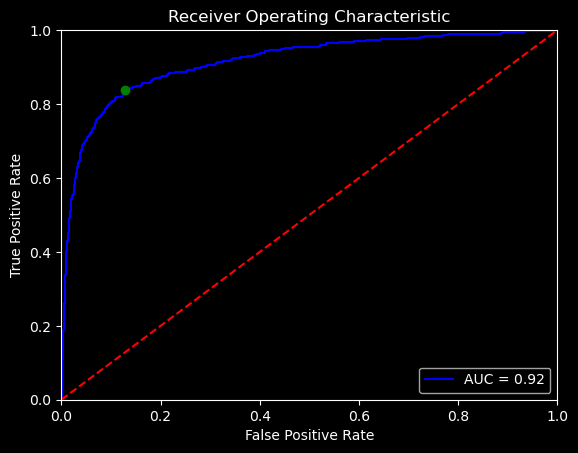

Optimal threshold value: 0.47142976943466164


In [324]:
# calculate the fpr and tpr for all thresholds of the classification
probs = best_model.predict_proba(TopF_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

# Add a dot for the optimal threshold
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = threshold[optimal_idx]
plt.plot(
    fpr[optimal_idx], tpr[optimal_idx], "go"
)  # This will mark the point on the curve that corresponds to the optimal threshold

plt.show()
print("Optimal threshold value:", optimal_threshold)

In [38]:
evaluate(best_model, TopF_train, TopF_test, y_train, y_test, optimal_threshold)

TRAINIG RESULTS:
CONFUSION MATRIX:
[[4091  457]
 [   0 2429]]
ACCURACY SCORE:
0.9345
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     1.000000     0.841649  0.934499     0.920825      0.944871
recall        0.899516     1.000000  0.934499     0.949758      0.934499
f1-score      0.947100     0.914017  0.934499     0.930559      0.935583
support    4548.000000  2429.000000  0.934499  6977.000000   6977.000000
AUC: 1.000
TESTING RESULTS:
CONFUSION MATRIX:
[[20534  3039]
 [   78   394]]
ACCURACY SCORE:
0.8704
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.996216    0.114768  0.870368      0.555492      0.978913
recall         0.871081    0.834746  0.870368      0.852914      0.870368
f1-score       0.929456    0.201793  0.870368      0.565624      0.915172
support    23573.000000  472.000000  0.870368  24045.000000  24045.000000
AUC: 0.915


In [323]:
optimal_threshold

0.47142976943466164

In [333]:
def test_model_visual(model, threshold, images, labels):
    # select 25 random images
    random_indices = np.random.choice(images.shape[0], size=50, replace=False)
    random_images = images[random_indices]
    random_labels = labels[random_indices]

    # get predictions from model
    feature_coord, feature_type = haar_like_feature_coord(
        width=19,
        height=19,
    )

    F_test_visual = [
        extract_feature_image(
            patch,
            feature_type=feature_type[f_indices],
            feature_coord=feature_coord[f_indices],
        )
        for patch in tqdm(random_images)
    ]
    F_test_visual = np.array(F_test_visual)

    y_test_pred_proba = model.predict_proba(F_test_visual)[:, 1]
    y_test_pred = y_test_pred_proba > threshold
    

    # plot the 25 random images, with their labels
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        ax.imshow(random_images[i], cmap="gray")

        label = "Face" if random_labels[i] else "Non-face"
        color_pred = "g" if y_test_pred[i] == random_labels[i] else "r"

        ax.set_title(label, color=color_pred)

        ax.axis("off")

    plt.tight_layout()

    plt.show()

100%|██████████| 50/50 [00:00<00:00, 540.72it/s]


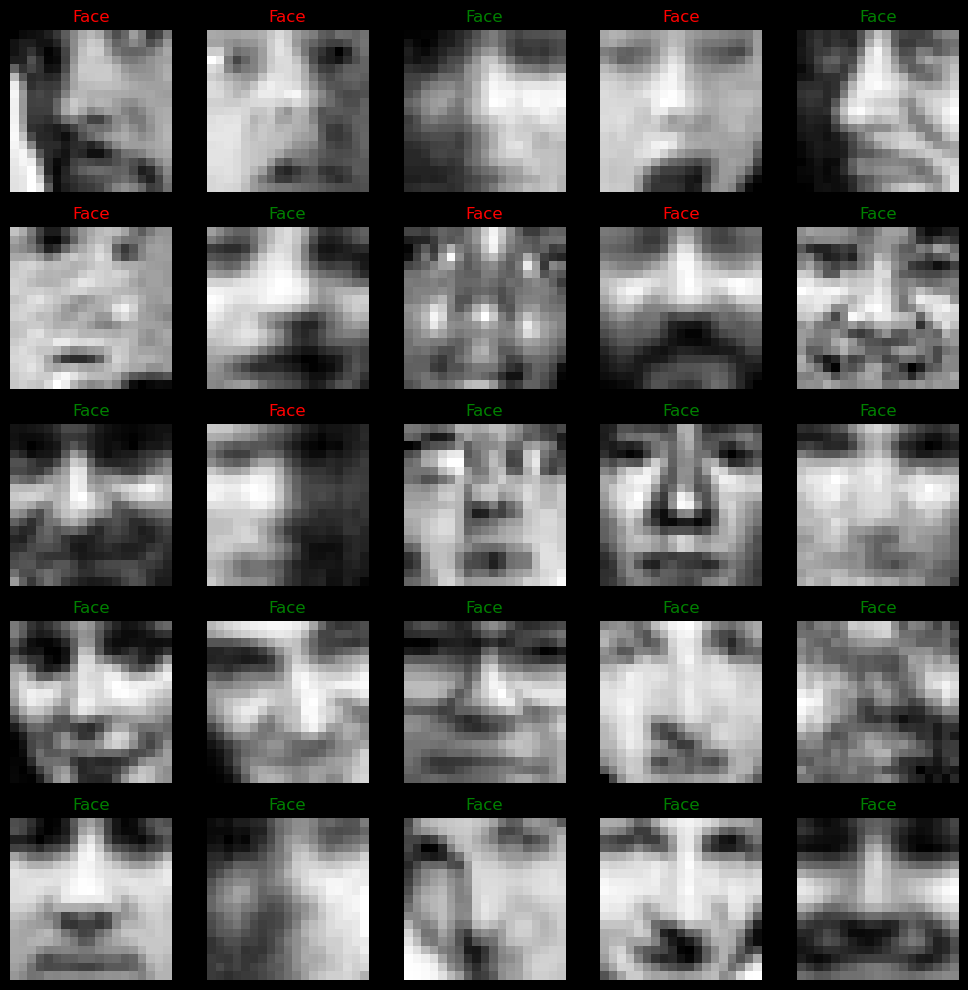

In [334]:
test_model_visual(best_model, optimal_threshold, np.array(test_faces_images), np.array([1] * len(test_faces_images)))

100%|██████████| 50/50 [00:00<00:00, 529.99it/s]


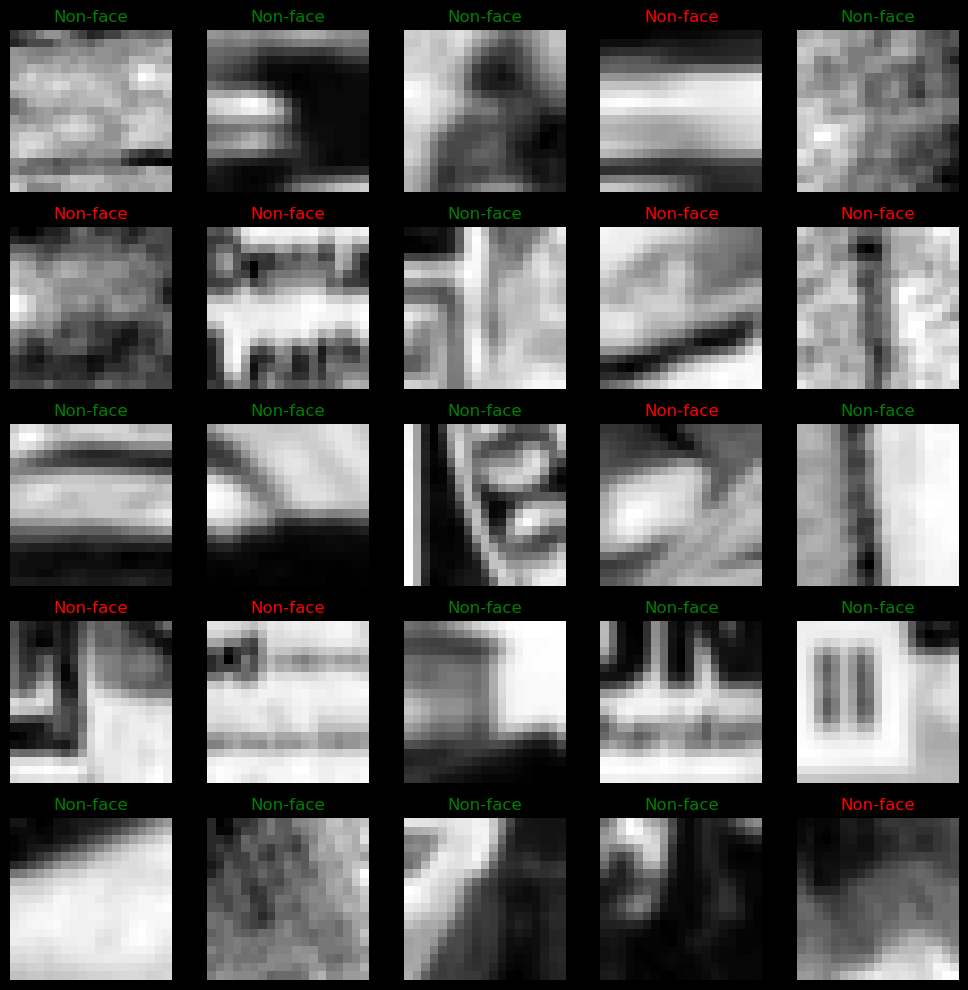

In [336]:
test_model_visual(best_model, optimal_threshold, np.array(test_background_images), np.array([0] * len(test_background_images)))

# Attentional Cascade

In the Viola-Jones framework, the face detection process is sped up by using a cascade of classifiers. This "attentional cascade" allows the algorithm to quickly discard non-face regions in an image, while spending more computational resources on promising face-like regions.

The cascade consists of stages, where each stage is a strong classifier. Each region of the image goes through the stages of the cascade sequentially. The key idea is that the majority of non-face regions of the image will be quickly discarded in the initial stages:

If a region is classified as a non-face by a stage, it is discarded, and doesn't pass through the remaining stages of the cascade.
If a region is classified as a face, it goes to the next stage.
This cascade structure allows the algorithm to focus its attention (hence "attentional cascade") on regions that are more likely to contain a face, and to do so in a computationally efficient manner. This is crucial for real-time face detection.

In our approach, we will design and implement this attentional cascade from scratch, adapting it to our specific task and data. We will create a series of stages (i.e., classifiers), train them with our face and non-face data, and cascade them to create our final face detection model.

In [337]:
# set seed
np.random.seed(42)

def cascada(models, thresholds, features_matrix):
    M = features_matrix
    indices = np.array(range(len(M))).reshape(-1, 1)

    for i in range(len(models)):
        if len(M) == 0:
            return [], M
        h = models[i]
        umbral = thresholds[i]
        p_hat_h = h.predict_proba(M)[:, 1]
        indices = indices[p_hat_h >= umbral, :]
        M = M[p_hat_h >= umbral, :]
    return indices.ravel(), M

In [338]:
# Separamos caras de background
pos_rows = [y == 1 for y in y_train]
neg_rows = [y == 0 for y in y_train]

pos = TopF_train[pos_rows, :]
neg = TopF_train[neg_rows, :]

In [339]:
models = []
n_features = []
thresholds = []

In [340]:
# Define the constants that we'll use for our AdaBoostClassifier
# Each of these lists represents different hyperparameters that we'll cycle through in the coming for loop
N_MAX =   [  10,   20,   30,   50,  100,  200] # List of maximum number of estimators for the AdaBoost algorithm
FPR_MAX = [0.70, 0.65, 0.55, 0.53, 0.53, 0.50] # List of maximum false positive rates for the model
TPR_MIN = [0.96, 0.96, 0.92, 0.92, 0.92, 0.95] # List of minimum true positive rates for the model
K_MAX = len(N_MAX)

# Function to train AdaBoost model with a specific number of estimators
def train_model(estimators):
    features_train = np.vstack((pos,neg)) # Stack positive and negative features vertically
    labels_train = [1]*len(pos)+[0]*len(neg) # Create labels: 1 for positive and 0 for negative
    hk = AdaBoostClassifier(
        DecisionTreeClassifier(criterion='entropy',max_depth=1),
        n_estimators=estimators
    )
    hk.fit(features_train, labels_train) # Train the model
    return hk

# Function to find the best threshold given certain conditions
def find_threshold(y_test_k, probas, estimator, fpr_max, tpr_min):
    n = 0
    exit = False
    while not exit:
        n = n + 1
        fpr, tpr, roc_thresholds = roc_curve(y_test_k, probas[:,n-1]) # Calculate false positive rate and true positive rate
        condition = (fpr<=fpr_max)*(tpr>=tpr_min) # Define condition for optimal threshold
        if (np.sum(condition) > 0):
            print('Threshold found for n='+str(n))
            idx = np.argmax(condition)
            return roc_thresholds[idx], n
        elif n == estimator:
            print('No threshold found for n='+str(n))
            gmeans = np.sqrt(tpr * (1-fpr))
            idx = np.argmax(gmeans)
            return roc_thresholds[idx], n

def get_probas(k, hk, thresholds):
    # Create test set and predict probabilities for the first round or subsequent rounds
    if k == 0:
        y_test_k = np.array(y_test)
        p_hat_hk = hk.staged_predict_proba(TopF_test)
        N = len(TopF_test)
    else:
        indices_k, M_train_k = cascada(models, thresholds, TopF_test)
        y_test_k = np.array(y_test)[indices_k]
        p_hat_hk = hk.staged_predict_proba(M_train_k)
        N = len(M_train_k)
    
    # Initialize a matrix to store probabilities
    probas = np.zeros((N, N_MAX[k]))
    for stage, p_pred in enumerate(p_hat_hk):
        # Fill the matrix with the predicted probabilities for each stage/layer
        probas[:,stage] = p_pred[:,1]

    return probas, y_test_k
        
# Start training models with different parameters
for k in tqdm(range(K_MAX)):

    if len(neg) == 0: # Stop if there are no more negative sample
        break
    
    hk = train_model(N_MAX[k]) # Train model with k-th number of estimators
    
    # Create test set and predict probabilities for the first round or subsequent rounds
    probas, y_test_k = get_probas(k, hk, thresholds)
    
    # Fill the matrix with the predicted probabilities for each stage/layer
    threshold, n = find_threshold(y_test_k, probas, N_MAX[k], FPR_MAX[k], TPR_MIN[k])

    # If the optimal number of estimators is less than max, retrain the classifier
    if n < N_MAX[k]:
        hk = train_model(n)
    
    # Store the threshold, the model and the number of features
    thresholds.append(threshold)
    models.append(hk)
    n_features.append(n)
    
    # Use the trained cascade model to filter out false positives
    indices_fp, _ = cascada(models, thresholds, neg)
    neg = neg[indices_fp,:]


  0%|          | 0/6 [00:00<?, ?it/s]

Threshold found for n=9


 17%|█▋        | 1/6 [01:05<05:27, 65.48s/it]

Threshold found for n=19


 33%|███▎      | 2/6 [02:47<05:47, 86.86s/it]

Threshold found for n=28


 50%|█████     | 3/6 [04:43<05:00, 100.33s/it]

Threshold found for n=48


 67%|██████▋   | 4/6 [07:22<04:06, 123.24s/it]

Threshold found for n=86


100%|██████████| 6/6 [16:01<00:00, 160.30s/it]

No threshold found for n=200


In [341]:
n_features

[9, 19, 28, 48, 86, 200]

In [342]:
thresholds

[0.20551386327221105,
 0.344931091778833,
 0.41470116329842166,
 0.44806047989749703,
 0.4754384162625114,
 0.4940968324002512]

In [343]:
models

[AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=1),
                    n_estimators=9),
 AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=1),
                    n_estimators=19),
 AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=1),
                    n_estimators=28),
 AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=1),
                    n_estimators=48),
 AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=1),
                    n_estimators=86),
 AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                

In [344]:
indices_test, _ = cascada(models, thresholds, TopF_test)

In [345]:
y_hat_test = [1 if idx in indices_test else 0 for idx in range(len(TopF_test))]

In [346]:
cm = confusion_matrix(y_test, y_hat_test)

In [347]:
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

FPR = FP / (FP + TN)
TPR = TP / (TP + FN)

print("FPR: ", FPR)
print("TPR: ", TPR)

FPR:  0.022822720909515124
TPR:  0.5423728813559322


In [348]:
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     23573
           1       0.32      0.54      0.40       472

    accuracy                           0.97     24045
   macro avg       0.66      0.76      0.69     24045
weighted avg       0.98      0.97      0.97     24045



In [349]:
from skimage.transform import resize


# Esta función explora las sub-ventanas a una escala dada
def sliding_window(img, patch_size=(19, 19), istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i : i + Ni, j : j + Nj]
            if scale != 1:
                patch = resize(patch, patch_size)
            yield (i, j), patch


def extract_features_patches(patches):
    feature_coord, feature_type = haar_like_feature_coord(
        width=19,
        height=19,
    )
    F_patches = [
        extract_feature_image(
            patch,
            feature_type=feature_type[f_indices],
            feature_coord=feature_coord[f_indices],
        )
        for patch in tqdm(patches)
    ]
    return np.array(F_patches)


def show_detions(image, indices, indices_patches, scale=1.0):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap="gray")
    ax.axis("off")

    pos_indices = np.array(indices)[indices_patches]

    for i, j in pos_indices:
        ax.add_patch(
            plt.Rectangle(
                (j, i),
                int(19 * scale),
                int(19 * scale),
                edgecolor="red",
                alpha=0.1,
                lw=2,
                facecolor="red",
            )
        )


def test_cascade(models, thresholds, image, istep, jstep, scale=1.0):
    indices, patches = zip(*sliding_window(image, istep=istep, jstep=jstep, scale=scale))
    patches_norm = [equalize_hist(patch) for patch in patches]
    F_patches = extract_features_patches(patches_norm)
    indices_patches, M = cascada(models, thresholds, F_patches)
    show_detions(image, indices, indices_patches, scale=scale)

In [351]:
thresholds

[0.20551386327221105,
 0.344931091778833,
 0.41470116329842166,
 0.44806047989749703,
 0.4754384162625114,
 0.4940968324002512]

100%|██████████| 84/84 [00:00<00:00, 607.39it/s]


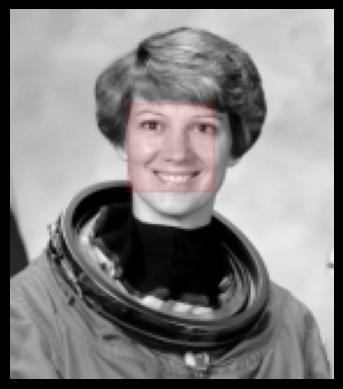

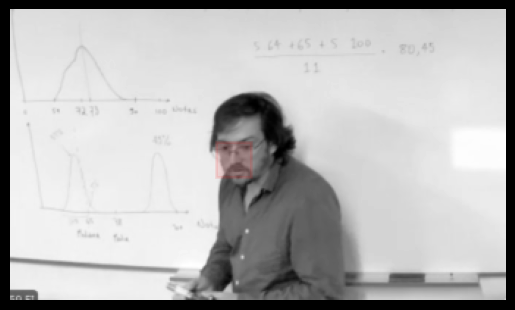

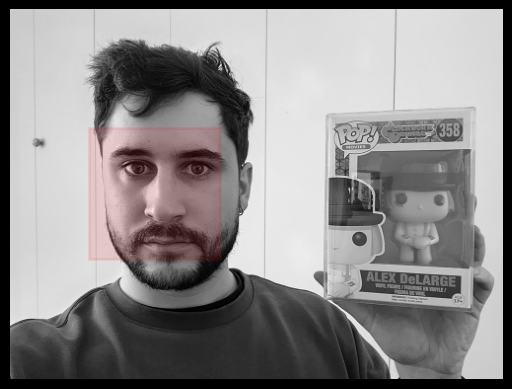

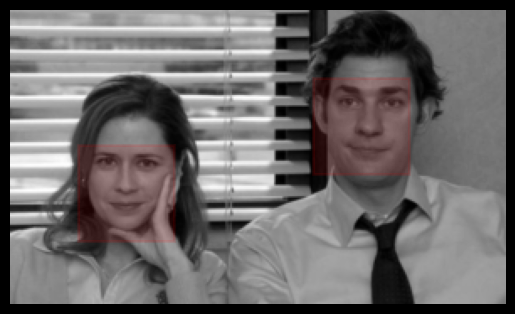

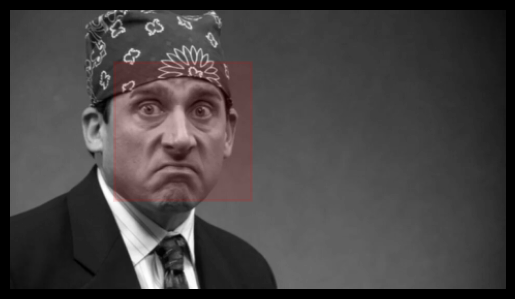

In [374]:
from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.transform import rescale

def astronaut_test(models, thresholds):
    test_image = astronaut()
    test_image = rgb2gray(test_image)
    test_image = rescale(test_image, 0.5)
    test_image = test_image[:160, 40:180]
    test_cascade(models, thresholds, test_image, istep=10, jstep=10, scale=2)

def teacher_test(models, thesholds):
    teacher_image = plt.imread('./assets/teacher.jpg')
    teacher_image = rgb2gray(teacher_image)
    teacher_image = rescale(teacher_image, 0.5)
    test_cascade(models, thresholds, teacher_image, istep=5, jstep=5, scale=1.3)

def student_test(models, thesholds):
    student_image = plt.imread('./assets/student.jpg')
    student_image = rgb2gray(student_image)
    student_image = rescale(student_image, 0.5)
    test_cascade(models, thresholds, student_image, istep=20, jstep=20, scale=7)

def pam_and_jim_test(models, thesholds):
    pam_and_jim_image = plt.imread('./assets/pam_and_jim.jpg')
    pam_and_jim_image = rgb2gray(pam_and_jim_image)
    pam_and_jim_image = rescale(pam_and_jim_image, 0.5)
    test_cascade(models, thresholds, pam_and_jim_image, istep=10, jstep=10, scale=3)

def michael_test(models, thesholds):
    michael_image = plt.imread('./assets/prison_mike.jpg')
    michael_image = rgb2gray(michael_image)
    michael_image = rescale(michael_image, 0.5)
    test_cascade(models, thresholds, michael_image, istep=25, jstep=25, scale=7)


astronaut_test(models, thresholds)
teacher_test(models, thresholds)
student_test(models, thresholds)
pam_and_jim_test(models, thresholds)
michael_test(models, thresholds)

## Evaluating a Cascade per stage

We will demonstrate how a given image evolves as it passes through each stage of the cascade. We will observe how non-face regions are progressively discarded, resulting in a set of regions that are likely to contain a face. This provides a visual understanding of the face detection process and helps us comprehend the efficiency of the cascade approach.

100%|██████████| 143/143 [00:00<00:00, 621.37it/s]


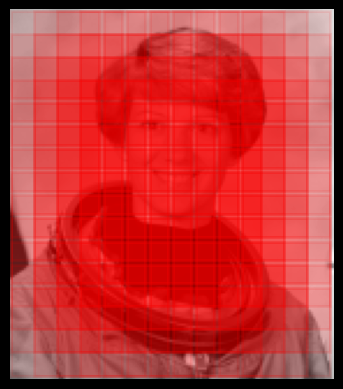

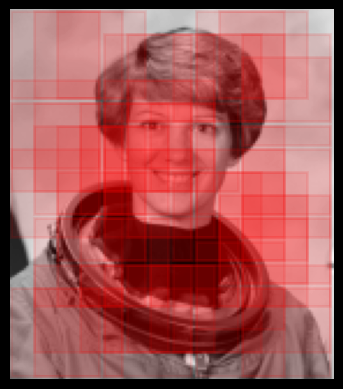

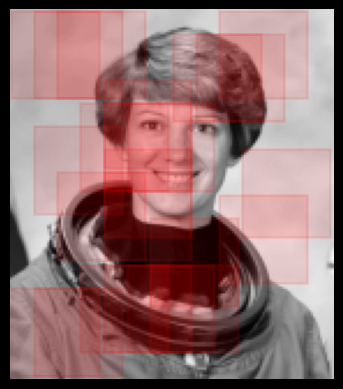

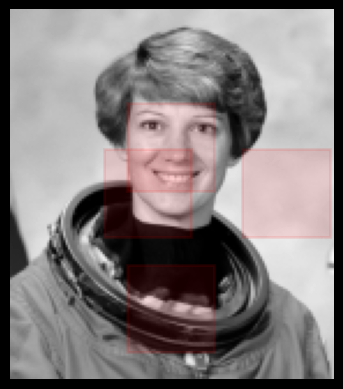

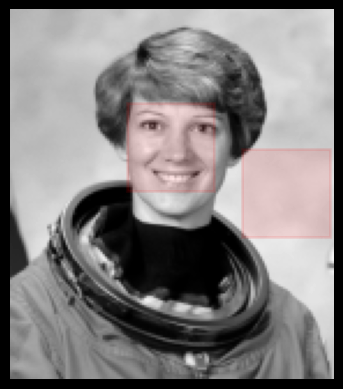

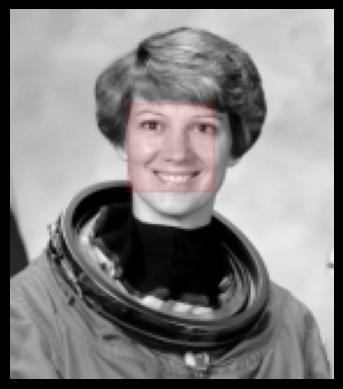

In [380]:
for i in range(len(models)):
    astronaut_test(models[:(i)], thresholds)

100%|██████████| 84/84 [00:00<00:00, 607.50it/s]


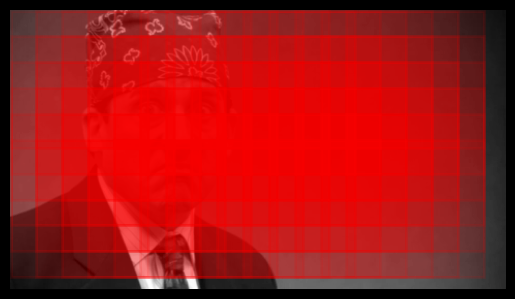

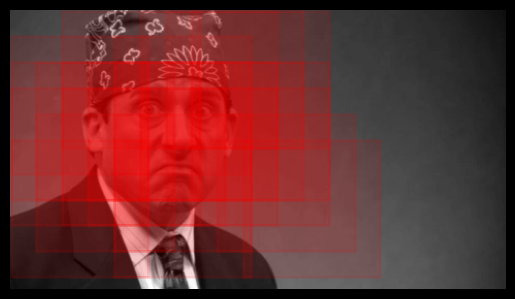

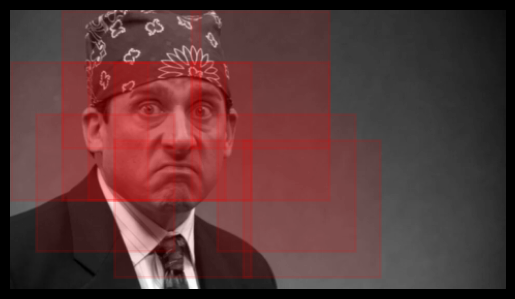

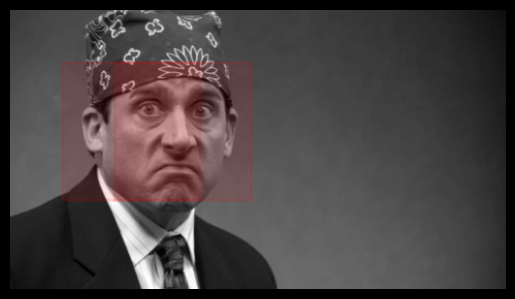

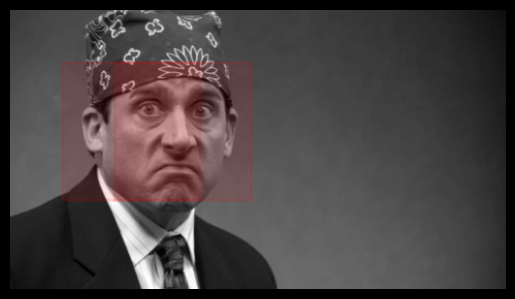

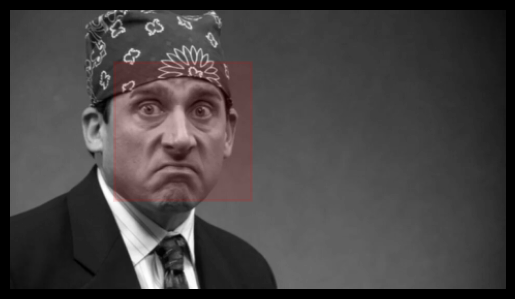

In [381]:
for i in range(len(models)):
    michael_test(models[:(i)], thresholds)

# Conclusion

In creating this notebook, my primary aim was to provide an educational resource for exploring a cascade of classifiers for face detection, a fascinating aspect of image processing and computer vision. The intention was not to deliver a production-level tool but rather to delve into a hands-on learning experience.

During this educational pursuit, it became apparent that the data I had initially collected was insufficient for a production-ready tool. Nonetheless, this seemingly negative discovery morphed into a valuable lesson: even with limited data, there are opportunities for growth and insight. It underscored the vital role robust data sets play in machine learning, while simultaneously illustrating the educational potential inherent even within the constraints of data scarcity.

Given the particular characteristics of my data set, specifically its imbalance, I opted to use an unconventional method of evaluation. Rather than using a separate validation set, I assessed the performance of my cascade directly on the test data. This performance was further verified on final images, such as the astronaut picture. This departure from the norm was driven by the desire to optimize learning from my limited data.

It's crucial to recognize that a considerable amount of fine-tuning went into the hyperparameters to optimize the cascade's final tests. While not a standard practice in most machine learning projects, the limitations of my data set nudged me towards this strategy. It was a conscious decision to maximize the learning opportunities from the data at hand, rather than strictly adhering to the more traditional validation method.

Navigating through this project has been an illuminating and inspiring journey. The obstacles encountered along the way fueled further research, innovation, and a more profound understanding of the subject. Despite not aiming for a production-grade solution, the experience of confronting the complexities of this project and ultimately bringing the cascade to life has been both rewarding and educational.

Unfortunately, this notebook does not encompass all the trials and tests undertaken during this project. For example, at one point, I experimented with incorporating a random forest into the cascade. Documenting all these endeavors would have resulted in an excessively lengthy notebook. Nevertheless, I am confident that this notebook accurately represents the linear progression of my thought processes, decisions, and the motivations behind them.

To conclude, this notebook stands as a testament to the power of machine learning and its potential applications in computer vision. Despite the challenges faced, I succeeded in creating a cascade of classifiers capable of effectively identifying faces in images. While this cascade might not be production-ready, the concepts and techniques explored here form a solid foundation for more advanced, production-grade face detection systems. It's a reminder that the path to mastery begins with a solid understanding of the fundamentals, and each step taken in this direction, no matter how small, is indeed a step forward.